In [1]:
import os
import shutil
import torch
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
# all_dir = os.path.join('Datasets', 'ASL-static', 'archive', 'train_all')
# for sign in os.listdir(train_directory):
#     for image in os.listdir(os.path.join(train_directory, sign)):
#         shutil.copy(os.path.join(train_directory, sign, image), os.path.join(all_dir, image))

In [3]:
train_dir = os.path.join('Datasets', 'ASL-static', 'archive', 'asl_alphabet_train')
train_all_dir = os.path.join('Datasets', 'ASL-static', 'archive', 'train_all')
test_dir = os.path.join('Datasets', 'ASL-static', 'archive', 'asl_alphabet_test')

sign_to_num = {l: i for i, l in enumerate(os.listdir(train_dir))}
num_to_sign = {i: l for l, i in sign_to_num.items()} 
one_hots = {sign: one_hot for sign, one_hot in zip(sign_to_num.keys(), F.one_hot(torch.tensor(list(sign_to_num.values())), num_classes=len(sign_to_num)))}

In [4]:
n_classes = len(sign_to_num)
learning_rate = 1e-3
batch_size = 32
n_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

Using cache found in C:\Users\Pranav/.cache\torch\hub\pytorch_vision_v0.10.0


In [6]:
class HandSignsDataset(Dataset):
    def __init__(self, directory, sign_to_num, preprocess=None):
        self.directory = directory
        self.img_files = os.listdir(directory)
        self.preprocess = preprocess
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, index):
        img_name = self.img_files[index]
        img_path = os.path.join(self.directory, img_name)
        img_class = "".join([i for i in img_name if not i.isdigit()])[:-4]
        image = Image.open(img_path)
        
        if self.preprocess:
            image = self.preprocess(image)
        
        return (image, sign_to_num[img_class])

In [7]:
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = HandSignsDataset(
    directory = train_all_dir,
    sign_to_num = one_hots,
    preprocess = preprocess
)

In [8]:
train_size = int(0.98 * len(dataset))
small_train_size = 5000
val_size = int(len(dataset) - train_size)//2
test_size = len(dataset) - train_size - val_size
train_size, small_train_size, val_size, test_size

(85260, 5000, 870, 870)

In [9]:
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
small_train_set, _ = torch.utils.data.random_split(train_set, [small_train_size, train_size-small_train_size])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
small_train_loader = DataLoader(dataset=small_train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
model.fc = torch.nn.Linear(2048, n_classes)

In [12]:
%%capture
model.to(device)

In [13]:
def train_model(model, dataloaders, criterion, optimizer, n_epochs, small=False):
    test_history = []
    for epoch in range(n_epochs):
        train_progress = tqdm(range(small_train_size if small else train_size))
        i = 0
        for inputs, labels in dataloaders['train']:
            if i%7 == 0:
                error = test(model, dataloaders['val'], criterion)
                print(error)
                test_history.append(error)
                model.train()
                
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()

            outputs, aux_outputs = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4*loss2
            loss.backward()
            optimizer.step()
            
            # print(f"Output shape: {outputs.shape}, Labels shape: {labels.shape}")
            _, preds = torch.max(outputs, 1)

            train_progress.update(len(inputs))

            del inputs
            del labels
            del outputs
            del aux_outputs
            del loss
            
            i += 1
            
    return test_history
            
def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    test_progress = tqdm(range(val_size))
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        
        test_progress.update(len(inputs))
        
        del inputs
        del labels
        del outputs
        del loss
        
    return running_loss/val_size

In [14]:
history = train_model(
    model = model,
    dataloaders = {'train': small_train_loader, 'val': val_loader},
    criterion = criterion,
    optimizer = optimizer,
    n_epochs = 1,
    small = True
)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/870 [00:00<?, ?it/s]

3.3940076066159652


  0%|          | 0/870 [00:00<?, ?it/s]

3.122786260199273


  0%|          | 0/870 [00:00<?, ?it/s]

2.3684970548783224


  0%|          | 0/870 [00:00<?, ?it/s]

1.3303673187891643


  0%|          | 0/870 [00:00<?, ?it/s]

1.5289320910113982


  0%|          | 0/870 [00:00<?, ?it/s]

0.9513198970378131


  0%|          | 0/870 [00:00<?, ?it/s]

0.598654844843108


  0%|          | 0/870 [00:00<?, ?it/s]

0.644799298527597


  0%|          | 0/870 [00:00<?, ?it/s]

0.55609021022402


  0%|          | 0/870 [00:00<?, ?it/s]

0.8330846720728381


  0%|          | 0/870 [00:00<?, ?it/s]

0.9835336964705895


  0%|          | 0/870 [00:00<?, ?it/s]

0.45185772708092614


  0%|          | 0/870 [00:00<?, ?it/s]

0.8258720384247001


  0%|          | 0/870 [00:00<?, ?it/s]

0.36452175135585085


  0%|          | 0/870 [00:00<?, ?it/s]

0.4784092244403116


  0%|          | 0/870 [00:00<?, ?it/s]

0.3760529119906754


  0%|          | 0/870 [00:00<?, ?it/s]

0.5322187010926762


  0%|          | 0/870 [00:00<?, ?it/s]

0.432519115935797


  0%|          | 0/870 [00:00<?, ?it/s]

0.3029915954789211


  0%|          | 0/870 [00:00<?, ?it/s]

0.21689141002194634


  0%|          | 0/870 [00:00<?, ?it/s]

0.25681119854936657


  0%|          | 0/870 [00:00<?, ?it/s]

0.32985603059160296


  0%|          | 0/870 [00:00<?, ?it/s]

0.4136763553509767


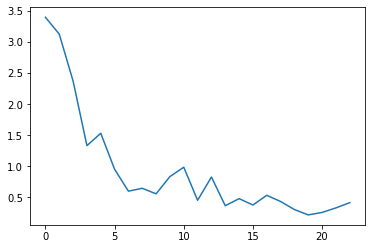

In [15]:
plt.plot(history)

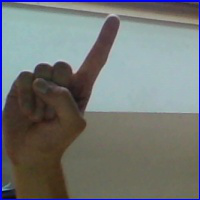

In [38]:
example_file_name = os.listdir(test_dir)[-1]
example = Image.open(os.path.join(test_dir, example_file_name))
example

In [39]:
example_file_name.split("_")[0]

'Z'

In [40]:
model.eval()
inp = preprocess(example).to(device)
outs = model(inp.unsqueeze(0))
num_to_sign[torch.argmax(outs).item()]

'X'

In [68]:
model.eval()
print("Actual\t\tPredicted\tConfidence\tCorrect")
corrects = wrongs = 0
for f in os.listdir(test_dir):
    test = Image.open(os.path.join(test_dir, f))
    actual_label = f.split("_")[0]
    inp = preprocess(test).to(device)
    outs = model(inp.unsqueeze(0))
    confidence = torch.max(torch.nn.Softmax(dim=1)(outs)).item()
    predicted_label = num_to_sign[torch.argmax(outs).item()]
    
    if actual_label == predicted_label:
        print("{a}\t\t{p}\t\t{c:.2%}\t\t✅".format(a=actual_label, p=predicted_label, c=confidence))
        corrects += 1
    else:
        print("{a}\t\t{p}\t\t{c:.2%}\t\t❌".format(a=actual_label, p=predicted_label, c=confidence))
        wrongs += 1
        
print("\nAccuracy: {:.2%}".format(corrects/(corrects+wrongs)))  

Actual		Predicted	Confidence	Correct
A		A		98.58%		✅
B		B		93.80%		✅
C		C		99.98%		✅
D		D		99.39%		✅
E		E		99.42%		✅
F		F		99.67%		✅
G		G		99.92%		✅
H		H		80.49%		✅
I		I		99.99%		✅
J		I		59.92%		❌
K		K		99.88%		✅
L		L		95.20%		✅
M		M		95.97%		✅
nothing		nothing		94.74%		✅
N		N		92.86%		✅
O		O		91.43%		✅
P		P		99.76%		✅
Q		Q		99.71%		✅
R		R		96.39%		✅
space		space		98.33%		✅
S		S		100.00%		✅
T		T		99.99%		✅
U		U		95.69%		✅
V		V		74.39%		✅
W		W		99.90%		✅
X		X		99.30%		✅
Y		Y		97.50%		✅
Z		X		60.64%		❌

Accuracy: 92.86%
